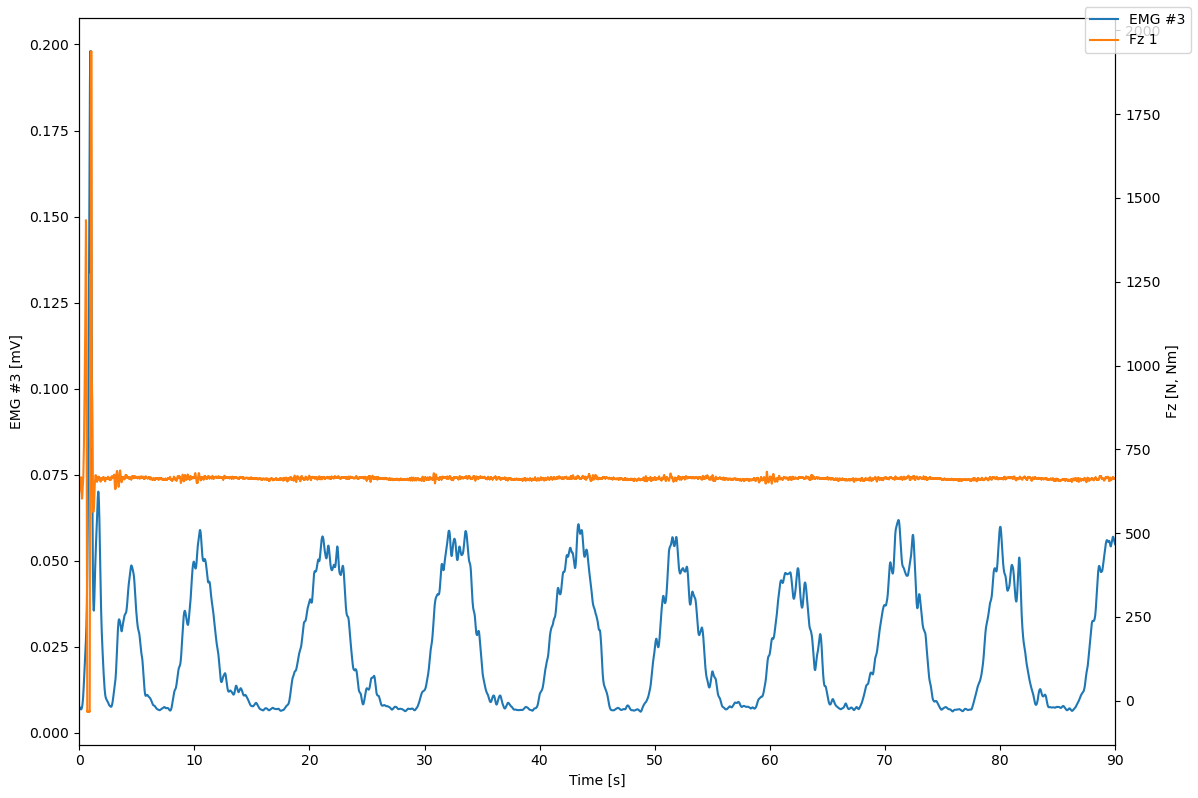

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from plot_emg import remove_offset, rectify, lpf

# Setup variables
t0 =  0.0                        # time of the beginning of the plot [s] (this time is included)
t1 = 90.0                        # time of the end of the plot [s] (this time is NOT included!)
filename_emg = "emg1.csv"         # filename of EMG data
filename_grf = "forceplate1.csv"  # filename of GRF data
figname = "../results/EMG_and_GRF1.png"      # filename of the output figure
idx_emg = 2  # EMG signal to be shown (0: EMG #1, 1: EMG #2, ..., 5: EMG #6)
idx_grf = 2  # GRF signal to be shown (0: Fx, 1: Fy, 2: Fz, 3: Mx, 4: My, 5: Mz)
t_offset = -9  # start time of the GRF signal with respect to that of the EMG signal [s]

# Load an EMG data.
df_emg = pd.read_csv(filename_emg, usecols=[0, 1, 21, 41, 61, 81, 101])
df_grf = pd.read_csv(filename_grf, header=31, usecols=[1, 3, 4, 5, 6, 7, 8])

# Remove not-available values in the end of the time column
df_emg = df_emg.dropna()

# Extract time and EMG data separately
times_emg = df_emg.values[:, 0]          # time [s]
data_emg  = df_emg.values[:, 1:] * 1000  # EMG values [mV]

# Extract time and GRF data separately
times_grf = df_grf.values[:, 0]  # time [s]
data_grf = df_grf.values[:, 1:]  # GRF values [N, Nm]

# Synchronize time of EMG and GRF signal
times_grf += t_offset

# Process the EMG data
def processing_data(data):
    data_emg = remove_offset(data)         # 1) Remove offset values
    data_emg = rectify(data_emg)               # 2) Rectify the data
    data_emg = lpf(data_emg, times_emg, fc=2)  # 3.1) Apply low-pass filter
    return data_emg

data_emg = processing_data(data_emg)

# Setup graph labels
labels_emg = ["EMG #1", "EMG #2", "EMG #3", "EMG #4", "EMG #5", "EMG #6"]
labels_grf = ["Fx", "Fy", "Fz", "Mx", "My", "Mz"]

# Plot the data
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx()
ax1.plot(times_emg, data_emg[:, idx_emg], color="C0", label=labels_emg[idx_emg])
ax2.plot(times_grf, data_grf[:, idx_grf], color="C1", label=labels_grf[idx_grf] + " 1")
ax1.set_xlabel("Time [s]")
ax1.set_xlim((t0, t1))
ax1.set_ylabel(labels_emg[idx_emg] + " [mV]")
ax2.set_ylabel(labels_grf[idx_grf] + " [N, Nm]")
fig.legend()
fig.tight_layout()

# Show the figure
plt.show()

In [2]:
# Inspecting both emg and grf
# print(df_emg.head())
# print(df_grf.head())

# Obtaining the time and EMG#3
emg3_time = pd.DataFrame()
emg3_time['Time'] = times_emg
emg3_time['EMG#3'] = data_emg[:, idx_emg]
# print(emg3_time.head())
# print(emg3_time.shape)

# Obtaining the time and Fz
grfz_time = pd.DataFrame()
grfz_time['Time'] = times_grf
grfz_time['Fz'] = data_grf[:, idx_grf]
# print(grfz_time.head())
# print(grfz_time.shape)

# Obtaining the EMG
emg_time = pd.DataFrame()
emg_time['Time'] = times_emg
for index, label in enumerate(labels_emg):
    emg_time[label] = data_emg[:, index]
print(emg_time.head())

# Combining 
combine = pd.merge_asof(grfz_time, emg3_time, on='Time', direction='nearest')
combine1 = pd.merge_asof(grfz_time, emg_time, on='Time', direction='nearest')
# print(combine1.head())
# print(combine1.shape)
combine1 = pd.melt(combine1, id_vars=['Fz'], value_vars=[emg for emg in combine1.columns[1:]], var_name='EMG', value_name='EMG Value')
print(combine1.head())

     Time    EMG #1    EMG #2    EMG #3    EMG #4    EMG #5    EMG #6
0  0.0000  0.037365  0.014126  0.007675  0.013310  0.030634  0.011045
1  0.0009  0.037395  0.014057  0.007669  0.013308  0.030452  0.011053
2  0.0018  0.037424  0.013987  0.007662  0.013306  0.030271  0.011062
3  0.0027  0.037454  0.013918  0.007656  0.013305  0.030089  0.011071
4  0.0036  0.037483  0.013849  0.007649  0.013304  0.029907  0.011079
          Fz     EMG  EMG Value
0  660.90625  EMG #1   0.037365
1  660.93750  EMG #1   0.037365
2  661.21875  EMG #1   0.037365
3  661.68750  EMG #1   0.037365
4  661.28125  EMG #1   0.037365


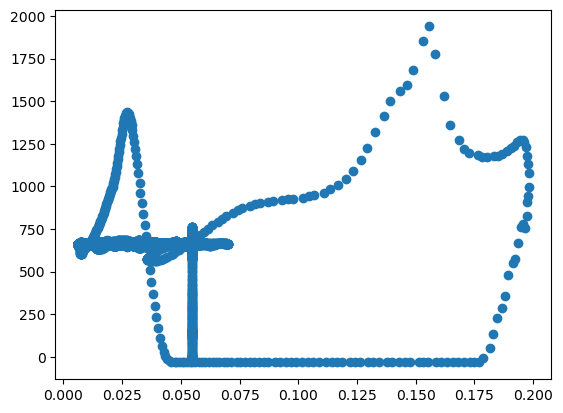

In [3]:
# Plotting
fig, ax = plt.subplots()
ax.scatter(combine['EMG#3'], combine['Fz'])
plt.show()

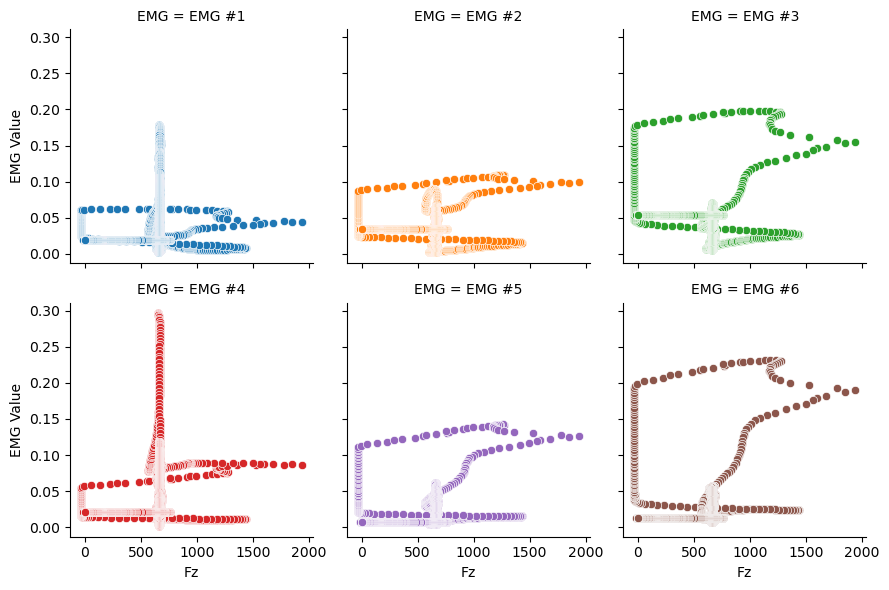

In [4]:
import seaborn as sns
g = sns.FacetGrid(combine1, col='EMG', hue='EMG', col_wrap=3)
g.map_dataframe(sns.scatterplot, x='Fz', y='EMG Value')
# sns.relplot(data=combine1, x='Fz', y='EMG Value', kind='scatter', hue='EMG', col='EMG', col_wrap=3)
plt.show()

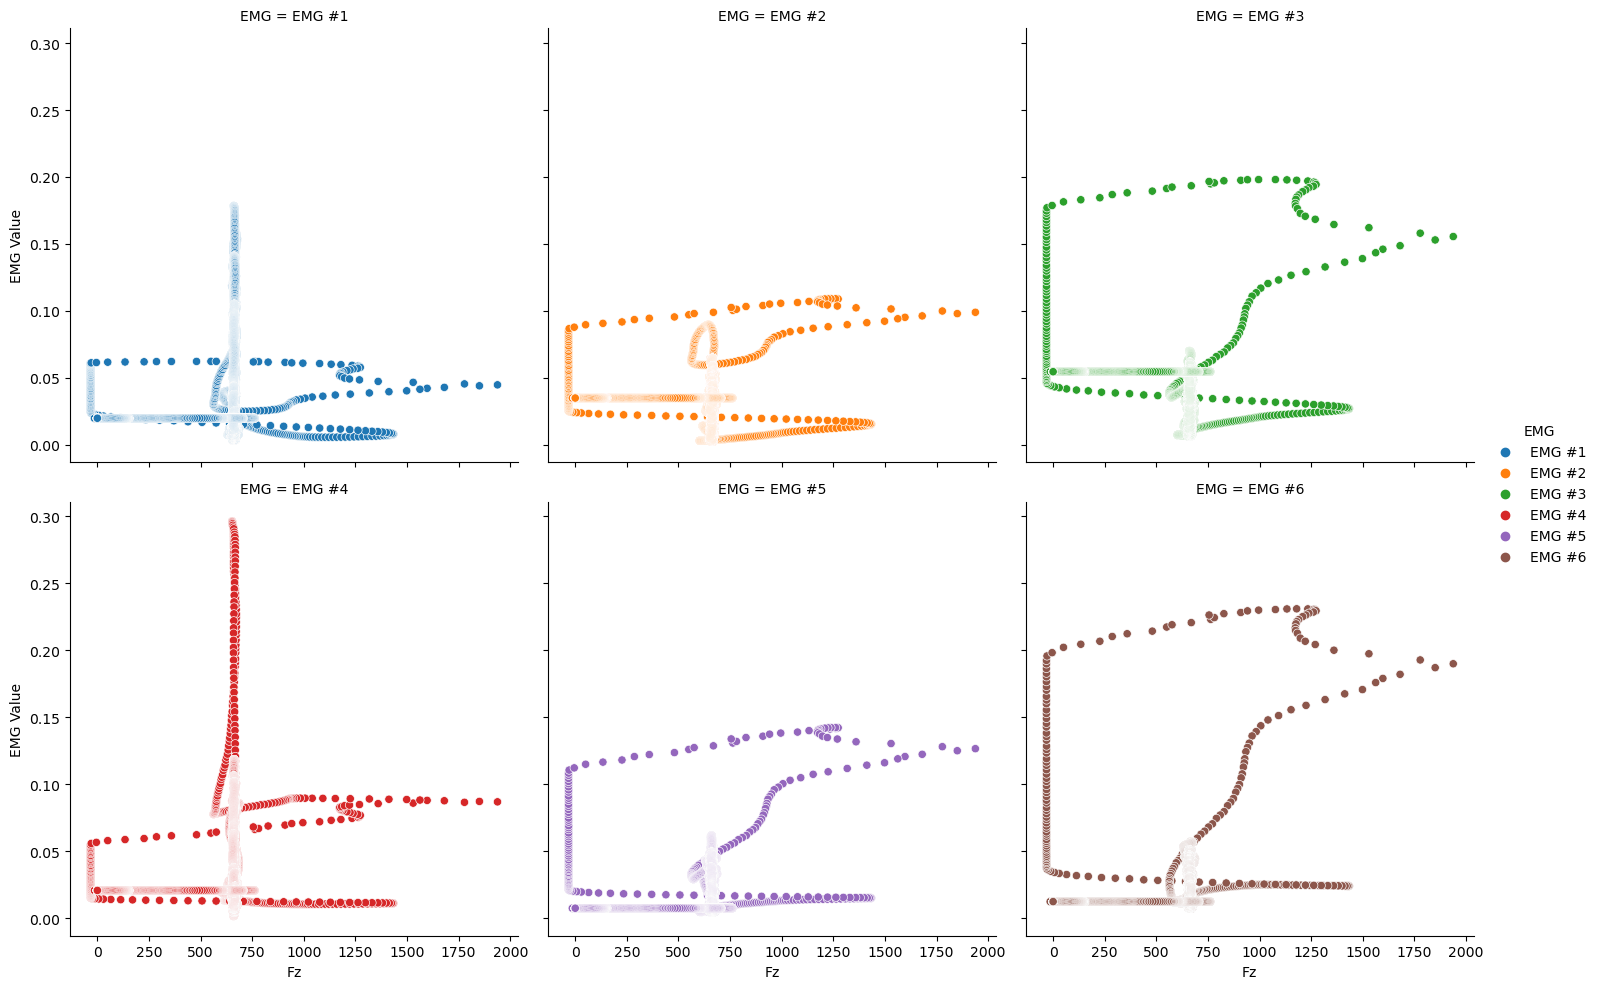

In [5]:
sns.relplot(data=combine1, x='Fz', y='EMG Value', kind='scatter', hue='EMG', col='EMG', col_wrap=3)
plt.show()

In [6]:
# Inspecting the maximum value (corresponds to the peak)
max_emg3 = emg3_time['EMG#3'].argmax()
print(max_emg3)
max_fz = grfz_time['Fz'].max()
max_emg3_time = emg3_time.iloc[emg3_time['EMG#3'].argmax(), :]
max_fz_time = grfz_time.iloc[grfz_time['Fz'].argmax(), :]
print(f'maximum value of EMG#3: \n{max_emg3_time}')
print(f'maximum value of Fz: \n{max_fz_time}')

# Obtaining the time difference
delta_t = max_emg3_time['Time'] - max_fz_time['Time'] 
print(f't_offset: {delta_t}')

1083
maximum value of EMG#3: 
Time     0.974700
EMG#3    0.198095
Name: 1083, dtype: float64
maximum value of Fz: 
Time       1.0530
Fz      1938.0625
Name: 3016, dtype: float64
t_offset: -0.07830000000000081
